# Procedural MLE Pipeline (no classes)

This notebook is the **procedural** conversion of `mle_simple.py` without `class`/`self`.

**Structure** (one logical cell each):

1. Imports & setup
2. Configuration / paths
3. Data loading & missingness analysis
4. Variable classification & normality + model specs
5. Likelihood function + optimizer
6. EM algorithm for missing data
7. Helpers: prepare/validate/visualize/save
8. High-level runner
9. Run cell (`if __name__ == '__main__'`)

Make sure the `Data/processed/` and `PLOTS/` directories exist or the code will create them.


In [1]:
# Cell 2: Imports & plotting backend
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# ensure matplotlib works in notebooks
%matplotlib inline


In [2]:
# Cell 3: Configuration / file paths
import os

# Get the project root directory - go up one level from Scripts/ to Project/
current_dir = os.path.dirname(os.path.abspath(''))
if current_dir.endswith('Scripts'):
    PROJECT_ROOT = os.path.dirname(current_dir)
else:
    PROJECT_ROOT = current_dir

# Alternative: try to find the project root by looking for Data/ directory
if not os.path.exists(os.path.join(PROJECT_ROOT, 'Data')):
    # Try current working directory
    if os.path.exists(os.path.join(os.getcwd(), 'Data')):
        PROJECT_ROOT = os.getcwd()
    # Try going up one level
    elif os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'Data')):
        PROJECT_ROOT = os.path.dirname(os.getcwd())

DATA_PATH = os.path.join(PROJECT_ROOT, 'Data', 'processed', 'cleaned_dataset_with_engineered_features.csv')
VAR_GROUP_PATH = os.path.join(PROJECT_ROOT, 'Data', 'processed', 'variable_grouping_table.csv')
RESULTS_PATH = os.path.join(PROJECT_ROOT, 'Data', 'processed', 'mle_results.json')
PLOTS_DIR = os.path.join(PROJECT_ROOT, 'PLOTS')

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(os.path.dirname(RESULTS_PATH), exist_ok=True)

# Default key variables
DEFAULT_KEY_CONTINUOUS = ['f1_bw', 'f0_m_age', 'f0_m_bmi_prepreg', 'f0_m_ht', 'f0_m_wt_prepreg']
DEFAULT_KEY_CATEGORICAL = ['f0_m_edu', 'f0_f_edu', 'f0_occ_hou_head', 'f1_sex']

print('Current directory:', current_dir)
print('Project root:', PROJECT_ROOT)
print('Data path:', DATA_PATH)
print('File exists:', os.path.exists(DATA_PATH))
print('Paths and folders set. PLOTS_DIR:', PLOTS_DIR)


Current directory: e:\KEM\Project
Project root: e:\KEM\Project
Data path: e:\KEM\Project\Data\processed\cleaned_dataset_with_engineered_features.csv
File exists: True
Paths and folders set. PLOTS_DIR: e:\KEM\Project\PLOTS


In [3]:
# Cell 4: Data loading & missingness analysis

def load_data(data_path=DATA_PATH, var_group_path=VAR_GROUP_PATH):
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Dataset not found: {data_path}")
    data = pd.read_csv(data_path)
    if not os.path.exists(var_group_path):
        raise FileNotFoundError(f"Variable grouping file not found: {var_group_path}")
    variable_groups = pd.read_csv(var_group_path)
    print(f"[OK] Loaded dataset: {data.shape[0]} rows, {data.shape[1]} columns")
    print(f"[OK] Loaded variable grouping: {len(variable_groups)} variables categorized")
    return data, variable_groups


def analyze_missing_patterns(data, key_continuous=DEFAULT_KEY_CONTINUOUS, key_categorical=DEFAULT_KEY_CATEGORICAL):
    missing_pct = (data.isnull().sum() / len(data)) * 100
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
    high = missing_pct[missing_pct > 20]
    moderate = missing_pct[(missing_pct > 5) & (missing_pct <= 20)]
    low = missing_pct[(missing_pct > 0) & (missing_pct <= 5)]
    print(f"[OK] High missing (>20%): {len(high)} variables")
    print(f"[OK] Moderate missing (5-20%): {len(moderate)} variables")
    print(f"[OK] Low missing (0-5%): {len(low)} variables")

    key_vars = [v for v in (key_continuous + key_categorical) if v in data.columns]
    if key_vars:
        plt.figure(figsize=(12, 8))
        sns.heatmap(data[key_vars].isnull().T, cbar=True, yticklabels=True, cmap='viridis')
        plt.title('Missing Data Pattern for Key Variables')
        plt.tight_layout()
        fn = os.path.join(PLOTS_DIR, 'missingness_heatmap_key_vars.png')
        plt.savefig(fn, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"[OK] Missingness heatmap saved: {fn}")


In [4]:
# Cell 5: Variable classification, normality testing, model specs

def classify_variables(data, variable_groups):
    continuous_vars = variable_groups.loc[variable_groups['Type'] == 'Continuous', 'Variable'].tolist()
    categorical_vars = variable_groups.loc[variable_groups['Type'] == 'Categorical', 'Variable'].tolist()
    continuous_vars = [v for v in continuous_vars if v in data.columns]
    categorical_vars = [v for v in categorical_vars if v in data.columns]
    print(f"[OK] Continuous variables detected: {len(continuous_vars)}")
    print(f"[OK] Categorical variables detected: {len(categorical_vars)}")
    return continuous_vars, categorical_vars


def test_normality(data, key_continuous=DEFAULT_KEY_CONTINUOUS):
    normality_results = {}
    for var in key_continuous:
        if var in data.columns:
            vals = data[var].dropna().values
            if len(vals) > 3:
                stat, p = stats.shapiro(vals)
                normality_results[var] = {'statistic': float(stat), 'p_value': float(p), 'is_normal': p > 0.05}
    normals = [v for v, r in normality_results.items() if r['is_normal']]
    non_normals = [v for v, r in normality_results.items() if not r['is_normal']]
    print(f"[OK] Normal vars: {len(normals)}; Non-normal vars: {len(non_normals)}")
    if non_normals:
        print(f"  Non-normal variables: {non_normals}")
    return normality_results


def define_model_specs(continuous_vars, categorical_vars, normality_results):
    model_specs = {
        'continuous': {
            'distribution': 'multivariate_normal',
            'parameters': ['mean_vector', 'covariance_matrix'],
            'variables': continuous_vars,
            'normal_variables': [v for v, r in normality_results.items() if r['is_normal']]
        },
        'categorical': {
            'distribution': 'multinomial',
            'parameters': ['probability_vectors'],
            'variables': categorical_vars
        },
        'mixed_model': {
            'framework': 'joint_likelihood',
            'continuous_part': 'multivariate_normal',
            'categorical_part': 'multinomial',
            'integration': 'expectation_maximization'
        }
    }
    print('[OK] Model specifications defined')
    return model_specs


In [5]:
# Cell 6: Likelihood function and optimizer

def multivariate_normal_log_likelihood(data, mean, cov):
    try:
        n, p = data.shape
        cov_reg = cov + np.eye(p) * 1e-6
        sign, logdet = np.linalg.slogdet(cov_reg)
        if sign <= 0:
            return -np.inf
        log_lik = -0.5 * n * p * np.log(2 * np.pi)
        log_lik -= 0.5 * n * logdet
        diff = data - mean
        inv_cov = np.linalg.inv(cov_reg)
        quadratic = np.sum(diff @ inv_cov * diff)
        log_lik -= 0.5 * quadratic
        return log_lik
    except np.linalg.LinAlgError:
        return -np.inf


def optimize_mle_for_multivariate_normal(data, likelihood_func):
    n_vars = data.shape[1]

    def neg_log_likelihood(params):
        mean = params[:n_vars]
        cov_params = params[n_vars:]
        cov = np.eye(n_vars)
        idx = 0
        for i in range(n_vars):
            for j in range(i, n_vars):
                if i == j:
                    cov[i, j] = np.exp(cov_params[idx])
                else:
                    cov[i, j] = cov_params[idx]
                    cov[j, i] = cov_params[idx]
                idx += 1
        return -likelihood_func(data, mean, cov)

    init_mean = np.nanmean(data, axis=0)
    init_cov_params = np.random.normal(0, 0.1, n_vars * (n_vars + 1) // 2)
    init_params = np.concatenate([init_mean, init_cov_params])

    res = minimize(neg_log_likelihood, init_params, method='BFGS')
    mean_est = res.x[:n_vars]
    cov_params = res.x[n_vars:]
    cov_est = np.eye(n_vars)
    idx = 0
    for i in range(n_vars):
        for j in range(i, n_vars):
            if i == j:
                cov_est[i, j] = np.exp(cov_params[idx])
            else:
                cov_est[i, j] = cov_params[idx]
                cov_est[j, i] = cov_params[idx]
            idx += 1

    final_ll = -res.fun
    return mean_est, cov_est, final_ll


In [6]:
# Cell 7: EM algorithm for missing data

def simple_em_for_missing(data, likelihood_func, max_iter=50, tol=1e-6):
    data = np.asarray(data, dtype=float)
    n, p = data.shape

    mean_curr = np.nanmean(data, axis=0)
    cov_curr = np.cov(np.nan_to_num(data).T) + np.eye(p) * 1e-6

    prev_ll = -np.inf
    ll_history = []
    converged = False

    for it in range(1, max_iter + 1):
        data_imputed = data.copy()
        for i in range(n):
            row = data[i]
            if np.isnan(row).any():
                obs_idx = ~np.isnan(row)
                miss_idx = np.isnan(row)
                if obs_idx.sum() == 0:
                    data_imputed[i, miss_idx] = mean_curr[miss_idx]
                else:
                    mu_o = mean_curr[obs_idx]
                    mu_m = mean_curr[miss_idx]
                    cov_oo = cov_curr[np.ix_(obs_idx, obs_idx)]
                    cov_mo = cov_curr[np.ix_(miss_idx, obs_idx)]
                    try:
                        inv_cov_oo = np.linalg.inv(cov_oo + np.eye(cov_oo.shape[0]) * 1e-6)
                        conditional_mean = mu_m + cov_mo @ inv_cov_oo @ (row[obs_idx] - mu_o)
                        data_imputed[i, miss_idx] = conditional_mean
                    except np.linalg.LinAlgError:
                        data_imputed[i, miss_idx] = mu_m

        mean_curr = np.mean(data_imputed, axis=0)
        cov_curr = np.cov(data_imputed.T) + np.eye(p) * 1e-6

        curr_ll = likelihood_func(data_imputed, mean_curr, cov_curr)
        ll_history.append(float(curr_ll))

        if it > 1 and abs(curr_ll - prev_ll) < tol:
            converged = True
            break
        prev_ll = curr_ll

    result = {
        'mean': mean_curr,
        'covariance': cov_curr,
        'likelihood': float(prev_ll),
        'iterations': it,
        'likelihood_history': ll_history,
        'converged': converged
    }
    return result


In [7]:
# Cell 8: Helpers (prepare, validate, visualize, save)

def prepare_continuous_matrix(data, analysis_vars):
    analysis_vars = [v for v in analysis_vars if v in data.columns]
    mat = data[analysis_vars].values
    print(f"[OK] Continuous data shape: {mat.shape}; variables: {analysis_vars}")
    return mat, analysis_vars


def validate_results(mean_est, cov_est):
    print(f"[OK] Mean shape: {mean_est.shape}")
    print(f"[OK] Covariance shape: {cov_est.shape}")
    eigvals = np.linalg.eigvals(cov_est)
    pd_flag = np.all(np.real(eigvals) > 0)
    print(f"[OK] Covariance positive definite (all eigenvals>0): {pd_flag}")
    return pd_flag


def create_visualizations_and_save(results, data_df, analysis_vars):
    ll_hist = results['likelihood_history']
    mean_est = results['mean']
    cov_est = results['covariance']

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(ll_hist, marker='o')
    plt.title('EM Algorithm Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.bar(range(len(mean_est)), mean_est)
    plt.title('Mean Parameter Estimates')
    plt.xlabel('Variable Index')
    plt.ylabel('Mean Value')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    sns.heatmap(cov_est, annot=True, fmt='.3f', cmap='coolwarm')
    plt.title('Covariance Matrix')

    plt.subplot(2, 2, 4)
    if len(analysis_vars) > 0 and analysis_vars[0] in data_df.columns:
        plt.hist(data_df[analysis_vars[0]].dropna(), bins=30)
        plt.title(f'Distribution: {analysis_vars[0]}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    fn = os.path.join(PLOTS_DIR, 'mle_results_visualization.png')
    plt.savefig(fn, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"[OK] Results visualization saved: {fn}")


def save_results_json(results, analysis_vars, out_path=RESULTS_PATH):
    out = {
        'convergence': {
            'converged': bool(results['converged']),
            'iterations': int(results['iterations']),
            'final_likelihood': float(results['likelihood'])
        },
        'continuous_parameters': {
            'variables': analysis_vars,
            'mean_vector': [float(x) for x in results['mean'].tolist()],
            'covariance_matrix': [[float(x) for x in row] for row in results['covariance'].tolist()]
        }
    }
    with open(out_path, 'w') as f:
        json.dump(out, f, indent=2)
    print(f"[OK] Results saved to JSON: {out_path}")


In [8]:
# Cell 9: High-level pipeline runner

def run_full_pipeline(data_path=DATA_PATH):
    data_df, variable_groups = load_data(data_path, VAR_GROUP_PATH)

    continuous_vars, categorical_vars = classify_variables(data_df, variable_groups)

    analyze_missing_patterns(data_df)

    normality = test_normality(data_df)

    model_specs = define_model_specs(continuous_vars, categorical_vars, normality)

    analysis_vars = [v for v in DEFAULT_KEY_CONTINUOUS if v in data_df.columns]
    if not analysis_vars:
        analysis_vars = continuous_vars[:min(3, len(continuous_vars))]
        print(f"[WARN] Default key continuous vars not found; using: {analysis_vars}")

    data_continuous, analysis_vars = prepare_continuous_matrix(data_df, analysis_vars)

    try:
        em_results = simple_em_for_missing(data_continuous, multivariate_normal_log_likelihood, max_iter=50, tol=1e-4)
        print("[OK] EM completed")
        validate_results(em_results['mean'], em_results['covariance'])
        create_visualizations_and_save(em_results, data_df, analysis_vars)
        save_results_json(em_results, analysis_vars)
        return em_results
    except Exception as e:
        print("[ERROR] EM pipeline failed:", str(e))
        if not np.isnan(data_continuous).any():
            mean_est, cov_est, ll = optimize_mle_for_multivariate_normal(data_continuous, multivariate_normal_log_likelihood)
            fallback_res = {
                'mean': mean_est,
                'covariance': cov_est,
                'likelihood': float(ll),
                'iterations': 0,
                'likelihood_history': [float(ll)],
                'converged': True
            }
            validate_results(mean_est, cov_est)
            create_visualizations_and_save(fallback_res, data_df, analysis_vars)
            save_results_json(fallback_res, analysis_vars)
            return fallback_res
        else:
            raise


In [9]:
# Cell 10: Run the pipeline (execute this cell to run)
if __name__ == '__main__':
    print('='*80)
    print('RUNNING PROCEDURAL MLE PIPELINE (notebook)')
    print('='*80)
    try:
        results = run_full_pipeline()
        print('\n' + '='*80)
        print('PIPELINE FINISHED SUCCESSFULLY')
        print('='*80)
    except Exception as exc:
        print('Pipeline failed with error:', str(exc))
        print('If running interactively, run cells step-by-step to debug.')


RUNNING PROCEDURAL MLE PIPELINE (notebook)
[OK] Loaded dataset: 791 rows, 856 columns
[OK] Loaded variable grouping: 855 variables categorized
[OK] Continuous variables detected: 707
[OK] Categorical variables detected: 148
[OK] High missing (>20%): 1 variables
[OK] Moderate missing (5-20%): 0 variables
[OK] Low missing (0-5%): 0 variables
[OK] Missingness heatmap saved: e:\KEM\Project\PLOTS\missingness_heatmap_key_vars.png
[OK] Normal vars: 0; Non-normal vars: 5
  Non-normal variables: ['f1_bw', 'f0_m_age', 'f0_m_bmi_prepreg', 'f0_m_ht', 'f0_m_wt_prepreg']
[OK] Model specifications defined
[OK] Continuous data shape: (791, 5); variables: ['f1_bw', 'f0_m_age', 'f0_m_bmi_prepreg', 'f0_m_ht', 'f0_m_wt_prepreg']
[OK] EM completed
[OK] Mean shape: (5,)
[OK] Covariance shape: (5, 5)
[OK] Covariance positive definite (all eigenvals>0): True
[OK] Results visualization saved: e:\KEM\Project\PLOTS\mle_results_visualization.png
[OK] Results saved to JSON: e:\KEM\Project\Data\processed\mle_result

In [10]:
# Inline pipeline execution (creates global vars for analysis)

# Step 1: Load
data_df, variable_groups = load_data(DATA_PATH, VAR_GROUP_PATH)

# Step 2: Classify
continuous_vars, categorical_vars = classify_variables(data_df, variable_groups)

# Step 3: Analyze missing data
analyze_missing_patterns(data_df)

# Step 4: Normality & model specs
normality = test_normality(data_df)
model_specs = define_model_specs(continuous_vars, categorical_vars, normality)

# Step 5: Prepare continuous data
analysis_vars = [v for v in DEFAULT_KEY_CONTINUOUS if v in data_df.columns]
if not analysis_vars:
    analysis_vars = continuous_vars[:min(3, len(continuous_vars))]
data_continuous, analysis_vars = prepare_continuous_matrix(data_df, analysis_vars)

# Step 6: Run EM (creates global em_results)
print('\\n[INFO] Running EM (this may take a while depending on data size)...')
em_results = simple_em_for_missing(data_continuous, multivariate_normal_log_likelihood, max_iter=100, tol=1e-4)
print('[INFO] EM finished.')

# Step 7: Validate and visualize
validate_results(em_results['mean'], em_results['covariance'])
create_visualizations_and_save(em_results, data_df, analysis_vars)
save_results_json(em_results, analysis_vars)


[OK] Loaded dataset: 791 rows, 856 columns
[OK] Loaded variable grouping: 855 variables categorized
[OK] Continuous variables detected: 707
[OK] Categorical variables detected: 148
[OK] High missing (>20%): 1 variables
[OK] Moderate missing (5-20%): 0 variables
[OK] Low missing (0-5%): 0 variables
[OK] Missingness heatmap saved: e:\KEM\Project\PLOTS\missingness_heatmap_key_vars.png
[OK] Normal vars: 0; Non-normal vars: 5
  Non-normal variables: ['f1_bw', 'f0_m_age', 'f0_m_bmi_prepreg', 'f0_m_ht', 'f0_m_wt_prepreg']
[OK] Model specifications defined
[OK] Continuous data shape: (791, 5); variables: ['f1_bw', 'f0_m_age', 'f0_m_bmi_prepreg', 'f0_m_ht', 'f0_m_wt_prepreg']
\n[INFO] Running EM (this may take a while depending on data size)...
[INFO] EM finished.
[OK] Mean shape: (5,)
[OK] Covariance shape: (5, 5)
[OK] Covariance positive definite (all eigenvals>0): True
[OK] Results visualization saved: e:\KEM\Project\PLOTS\mle_results_visualization.png
[OK] Results saved to JSON: e:\KEM\Proj

## ✅ MLE Parameter Estimates

**Mean vector (per variable)**

,estimate
f1_bw,2575.676277
f0_m_age,21.307753
f0_m_bmi_prepreg,17.966873
f0_m_ht,151.576290
f0_m_wt_prepreg,41.312074


**Covariance matrix**

,f1_bw,f0_m_age,f0_m_bmi_prepreg,f0_m_ht,f0_m_wt_prepreg
f1_bw,164578.604964,227.528561,17.072885,800.619959,478.838901
f0_m_age,227.528561,12.334596,-0.399985,2.357101,0.382313
f0_m_bmi_prepreg,17.072885,-0.399985,8.517011,-13.403843,12.360295
f0_m_ht,800.619959,2.357101,-13.403843,90.184623,18.252815
f0_m_wt_prepreg,478.838901,0.382313,12.360295,18.252815,38.590851


## 🔍 Convergence & Likelihood

,converged,iterations,final_log_likelihood
0,True,2,-12819.658075


## 📊 RMSE Baseline (observed vs model mean)

,rmse
f0_m_bmi_prepreg,2.916546
f0_m_age,3.509843
f0_m_wt_prepreg,6.208225
f0_m_ht,9.490554
f1_bw,405.426369


**Overall baseline RMSE (observed → model mean):** `181.394586`

## 📈 Likelihood History

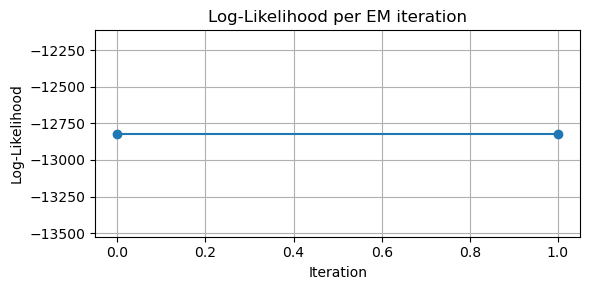

## 🧾 Sample Imputed Data (first 8 rows)

,f1_bw,f0_m_age,f0_m_bmi_prepreg,f0_m_ht,f0_m_wt_prepreg
0,2000.00000,22.0,19.387963,154.2,46.1
1,2650.00000,22.0,15.524087,158.5,39.0
2,2690.00000,20.0,16.366179,145.4,34.6
3,3350.00000,35.0,30.707596,149.9,69.0
4,2500.00000,16.0,17.408273,149.1,38.7
5,2233.18374,23.0,16.576422,152.4,38.5
6,2700.00000,17.0,17.743765,154.4,42.3
7,2650.00000,16.0,21.796114,144.8,45.7


### Done — parameter tables, RMSE baseline and sample imputed data shown above.

[OK] Continuous data shape: (791, 5); variables: ['f1_bw', 'f0_m_age', 'f0_m_bmi_prepreg', 'f0_m_ht', 'f0_m_wt_prepreg']


## 🧪 Masking Evaluation (imputation RMSE on masked entries)

,rmse_masked
f0_m_bmi_prepreg,0.125184
f0_m_wt_prepreg,0.799011
f0_m_ht,1.564288
f0_m_age,2.814950
f1_bw,358.069933
overall_rmse_masked,161.354887


**Masked-entry RMSE (overall):** `161.354887`

In [11]:
# Display & Evaluation (requires em_results, analysis_vars, data_df, data_continuous)
import pandas as pd
import numpy as np
from math import sqrt
from IPython.display import display, Markdown

def rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return np.sqrt(np.nanmean((a - b) ** 2))

def display_mle_results_inline(results, analysis_vars, data_df, data_continuous):
    mean_vec = np.asarray(results['mean'])
    cov_mat = np.asarray(results['covariance'])
    
    mean_df = pd.DataFrame(mean_vec.reshape(1, -1), columns=analysis_vars)
    cov_df = pd.DataFrame(cov_mat, index=analysis_vars, columns=analysis_vars)
    
    display(Markdown("## ✅ MLE Parameter Estimates"))
    display(Markdown("**Mean vector (per variable)**"))
    display(mean_df.T.rename(columns={0: 'estimate'}))
    display(Markdown("**Covariance matrix**"))
    display(cov_df)
    
    display(Markdown("## 🔍 Convergence & Likelihood"))
    converged = bool(results.get('converged', False))
    iters = int(results.get('iterations', 0))
    final_ll = float(results.get('likelihood', np.nan))
    display(pd.DataFrame({
        'converged': [converged],
        'iterations': [iters],
        'final_log_likelihood': [final_ll]
    }))
    
    display(Markdown("## 📊 RMSE Baseline (observed vs model mean)"))
    per_var_rmse = {}
    overall_errors = []
    total_obs = 0
    for j, var in enumerate(analysis_vars):
        col_vals = data_continuous[:, j]
        mask_obs = ~np.isnan(col_vals)
        if mask_obs.sum() == 0:
            per_var_rmse[var] = np.nan
            continue
        preds = np.full_like(col_vals[mask_obs], mean_vec[j], dtype=float)
        obs = col_vals[mask_obs].astype(float)
        r = rmse(obs, preds)
        per_var_rmse[var] = r
        overall_errors.append((obs.size) * (r**2))
        total_obs += obs.size
    
    if overall_errors and total_obs>0:
        overall_rmse = sqrt(sum(overall_errors) / total_obs)
    else:
        overall_rmse = np.nan
    
    per_var_rmse_df = pd.DataFrame.from_dict(per_var_rmse, orient='index', columns=['rmse']).sort_values('rmse', ascending=True)
    display(per_var_rmse_df)
    display(Markdown(f"**Overall baseline RMSE (observed → model mean):** `{overall_rmse:.6f}`"))
    
    display(Markdown("## 📈 Likelihood History"))
    import matplotlib.pyplot as plt
    hist = results.get('likelihood_history', [])
    if hist:
        plt.figure(figsize=(6,3))
        plt.plot(hist, marker='o')
        plt.title('Log-Likelihood per EM iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Log-Likelihood')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        display(Markdown("_No likelihood history available_"))
    
    display(Markdown("## 🧾 Sample Imputed Data (first 8 rows)"))
    mean_final = mean_vec
    cov_final = cov_mat
    data_imputed = np.array(data_continuous, dtype=float).copy()
    nrows, ncols = data_imputed.shape
    for i in range(nrows):
        row = data_imputed[i]
        if np.isnan(row).any():
            obs_idx = ~np.isnan(row)
            miss_idx = np.isnan(row)
            if obs_idx.sum() == 0:
                data_imputed[i, miss_idx] = mean_final[miss_idx]
            else:
                mu_o = mean_final[obs_idx]
                mu_m = mean_final[miss_idx]
                cov_oo = cov_final[np.ix_(obs_idx, obs_idx)]
                cov_mo = cov_final[np.ix_(miss_idx, obs_idx)]
                try:
                    inv_cov_oo = np.linalg.inv(cov_oo + np.eye(cov_oo.shape[0]) * 1e-6)
                    conditional_mean = mu_m + cov_mo @ inv_cov_oo @ (row[obs_idx] - mu_o)
                    data_imputed[i, miss_idx] = conditional_mean
                except np.linalg.LinAlgError:
                    data_imputed[i, miss_idx] = mu_m
    imputed_df = pd.DataFrame(data_imputed, columns=analysis_vars)
    display(imputed_df.head(8))
    
    display(Markdown("### Done — parameter tables, RMSE baseline and sample imputed data shown above."))

def evaluate_imputation_via_masking(original_df, analysis_vars, mask_fraction=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    full_mat, _ = prepare_continuous_matrix(original_df, analysis_vars)
    n, p = full_mat.shape
    obs_positions = [(i, j) for i in range(n) for j in range(p) if not np.isnan(full_mat[i, j])]
    if len(obs_positions) == 0:
        raise ValueError("No observed entries to mask for evaluation.")
    k_mask = max(1, int(len(obs_positions) * mask_fraction))
    mask_idx = rng.choice(len(obs_positions), size=k_mask, replace=False)
    masked_positions = [obs_positions[i] for i in mask_idx]
    masked_mat = full_mat.copy()
    for (i, j) in masked_positions:
        masked_mat[i, j] = np.nan
    em_masked_res = simple_em_for_missing(masked_mat, multivariate_normal_log_likelihood, max_iter=100, tol=1e-5)
    mean_final = np.asarray(em_masked_res['mean'])
    cov_final = np.asarray(em_masked_res['covariance'])
    imputed_masked = masked_mat.copy().astype(float)
    for i in range(n):
        row = imputed_masked[i]
        if np.isnan(row).any():
            obs_idx = ~np.isnan(row)
            miss_idx = np.isnan(row)
            if obs_idx.sum() == 0:
                imputed_masked[i, miss_idx] = mean_final[miss_idx]
            else:
                mu_o = mean_final[obs_idx]
                mu_m = mean_final[miss_idx]
                cov_oo = cov_final[np.ix_(obs_idx, obs_idx)]
                cov_mo = cov_final[np.ix_(miss_idx, obs_idx)]
                try:
                    inv_cov_oo = np.linalg.inv(cov_oo + np.eye(cov_oo.shape[0]) * 1e-6)
                    conditional_mean = mu_m + cov_mo @ inv_cov_oo @ (row[obs_idx] - mu_o)
                    imputed_masked[i, miss_idx] = conditional_mean
                except np.linalg.LinAlgError:
                    imputed_masked[i, miss_idx] = mu_m
    y_true = []
    y_pred = []
    for (i, j) in masked_positions:
        y_true.append(full_mat[i, j])
        y_pred.append(imputed_masked[i, j])
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask_rmse = rmse(y_true, y_pred)
    per_var = {}
    for j, var in enumerate(analysis_vars):
        idxs = [k for k, (i, jj) in enumerate(masked_positions) if jj == j]
        if len(idxs) == 0:
            per_var[var] = np.nan
            continue
        tv = y_true[idxs]
        pv = y_pred[idxs]
        per_var[var] = rmse(tv, pv)
    report = pd.DataFrame.from_dict(per_var, orient='index', columns=['rmse_masked']).sort_values('rmse_masked')
    report.loc['overall_rmse_masked'] = mask_rmse
    display(Markdown("## 🧪 Masking Evaluation (imputation RMSE on masked entries)"))
    display(report)
    display(Markdown(f"**Masked-entry RMSE (overall):** `{mask_rmse:.6f}`"))
    return em_masked_res, report

# Execute display + evaluation
display_mle_results_inline(em_results, analysis_vars, data_df, data_continuous)
em_masked_res, eval_report = evaluate_imputation_via_masking(data_df, analysis_vars, mask_fraction=0.05, random_state=2025)
